# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json

import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
import os

env_path = '../../data/.env'
load_dotenv(dotenv_path=env_path)

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [2]:
project = hopsworks.login(project='mlfs_lab1')
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163420
2024-11-13 22:29:57,542 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=3,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=5,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

We have previously implemented an air quality prediction system using a single model [here](https://github.com/AMomozZz/mlfs-book), where we included features based on the previous 20 days of data to predict air quality for the next 10 days. This ensured that at least half of the data used for predictions was actual historical data.

In this new approach, we experiment with using two models: one is similar to the original model, while the other utilizes data from the past 21 days, excluding data from the previous day. The hypothesis is that incorporating a larger proportion of real historical data will lead to more accurate predictions. Below, we demonstrate that using two models can yield more reliable results than using only one:

Let:

- `M` be the number of PM2.5 predictions in the feature set.

- `N` be the total number of PM2.5 values in the feature set.

- `k` be the number of models.

We begin by predicting air quality for the day after tomorrow, with  M = 1, k = 2:
$$
\begin{cases}
N\\
N - 1 \textcolor{red}{+ 1}
\end{cases}
$$

This allows us to derive the respective proportions of actual PM2.5 values and predicted values in the final forecast. In the current implementation, the results of both models are **averaged** to generate the final prediction:

$$\frac{N + (N - 1 \textcolor{red}{+ 1})}{2} = N - \frac{1}{2} + \textcolor{red}{\frac{1}{2}}$$

Then we generalize the values of M, we will obtain the following formula:

$$
\begin{cases}
N - (M - 1) \textcolor{red}{+ (M - 1)}\\
N - M \textcolor{red}{+ M}
\end{cases}
$$
$$\Downarrow$$
$$\frac{N - (M - 1) \textcolor{red}{+ M - 1} + (N - M \textcolor{red}{+ M})}{2} = N - M + \frac{1}{2} \textcolor{red}{+ M - \frac{1}{2}} $$

If we use a single model, the prediction relies on $ N - M \textcolor{red}{+ M} $ data points. However, using two models increases the proportion of actual data, thereby potentially improving prediction accuracy.

If the accuracy remains suboptimal even with two models, we can extend this approach by increasing the number of models k, resulting in the following formula:

$$
\begin{cases}
N - (M - (k - 1)) \textcolor{red}{+ (M - (k - 1))}\\
...\\
N - M \textcolor{red}{+ M}
\end{cases}
$$
$$\Downarrow$$
$$\frac{\sum_{i = 1} ^k N - (M - (i - 1)) \textcolor{red}{+ (M - (i - 1))}}{k} = N - M + \frac{k - 1}{2} \textcolor{red}{+ M - \frac{k - 1}{2}} $$

The formula shows that increasing the number of models primarily impacts the constant term, resulting in slight improvements. However, it still boosts the proportion of true data as more models are added, enhancing the overall prediction reliability.

In [6]:
# Select features for training data.
selected_features1 = air_quality_fg.select(['pm25']).join(weather_fg.select_except(['pm25_21']), on=['city'])
# selected_features.show(10)

selected_features1.read().sort_values(by=['date'], ascending=True).tail(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.06s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,...,pm25_11,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20
3924,124.0,2024-11-04 00:00:00+00:00,17.409084,0.0,19.645580,10.283305,shanghai,140.0,103.0,20.0,...,46.0,95.0,104.0,82.0,48.0,52.0,73.0,68.0,71.0,108.0
3925,45.0,2024-11-05 00:00:00+00:00,13.817414,0.0,19.852295,358.205353,shanghai,124.0,140.0,103.0,...,47.0,46.0,95.0,104.0,82.0,48.0,52.0,73.0,68.0,71.0
3926,35.0,2024-11-06 00:00:00+00:00,13.725750,0.0,17.589418,15.969136,shanghai,45.0,124.0,140.0,...,23.0,47.0,46.0,95.0,104.0,82.0,48.0,52.0,73.0,68.0
3927,35.0,2024-11-07 00:00:00+00:00,14.234082,0.0,14.450535,34.656887,shanghai,35.0,45.0,124.0,...,34.0,23.0,47.0,46.0,95.0,104.0,82.0,48.0,52.0,73.0
3928,55.0,2024-11-08 00:00:00+00:00,17.711164,0.0,18.275984,44.213470,shanghai,35.0,35.0,45.0,...,115.0,34.0,23.0,47.0,46.0,95.0,104.0,82.0,48.0,52.0
3929,46.0,2024-11-09 00:00:00+00:00,18.850750,0.5,21.862406,43.717545,shanghai,55.0,35.0,35.0,...,49.0,115.0,34.0,23.0,47.0,46.0,95.0,104.0,82.0,48.0
3930,61.0,2024-11-10 00:00:00+00:00,16.086168,1.2,18.553974,0.802675,shanghai,46.0,55.0,35.0,...,54.0,49.0,115.0,34.0,23.0,47.0,46.0,95.0,104.0,82.0
3931,87.0,2024-11-11 00:00:00+00:00,16.271584,0.0,14.092977,25.547438,shanghai,61.0,46.0,55.0,...,49.0,54.0,49.0,115.0,34.0,23.0,47.0,46.0,95.0,104.0
3932,93.0,2024-11-12 00:00:00+00:00,17.000000,0.0,5.091168,44.999897,shanghai,87.0,61.0,46.0,...,20.0,49.0,54.0,49.0,115.0,34.0,23.0,47.0,46.0,95.0
3933,72.0,2024-11-13 00:00:00+00:00,17.650000,0.0,7.895416,114.227737,shanghai,93.0,87.0,61.0,...,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0,47.0,46.0


In [7]:
selected_features2 = air_quality_fg.select(['pm25']).join(weather_fg.select_except(['pm25_1']), on=['city'])

selected_features2.read().sort_values(by=['date'], ascending=True).tail(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.47s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_2,pm25_3,pm25_4,...,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,pm25_21
3924,124.0,2024-11-04 00:00:00+00:00,17.409084,0.0,19.645580,10.283305,shanghai,103.0,20.0,49.0,...,95.0,104.0,82.0,48.0,52.0,73.0,68.0,71.0,108.0,60.0
3925,45.0,2024-11-05 00:00:00+00:00,13.817414,0.0,19.852295,358.205353,shanghai,140.0,103.0,20.0,...,46.0,95.0,104.0,82.0,48.0,52.0,73.0,68.0,71.0,108.0
3926,35.0,2024-11-06 00:00:00+00:00,13.725750,0.0,17.589418,15.969136,shanghai,124.0,140.0,103.0,...,47.0,46.0,95.0,104.0,82.0,48.0,52.0,73.0,68.0,71.0
3927,35.0,2024-11-07 00:00:00+00:00,14.234082,0.0,14.450535,34.656887,shanghai,45.0,124.0,140.0,...,23.0,47.0,46.0,95.0,104.0,82.0,48.0,52.0,73.0,68.0
3928,55.0,2024-11-08 00:00:00+00:00,17.711164,0.0,18.275984,44.213470,shanghai,35.0,45.0,124.0,...,34.0,23.0,47.0,46.0,95.0,104.0,82.0,48.0,52.0,73.0
3929,46.0,2024-11-09 00:00:00+00:00,18.850750,0.5,21.862406,43.717545,shanghai,35.0,35.0,45.0,...,115.0,34.0,23.0,47.0,46.0,95.0,104.0,82.0,48.0,52.0
3930,61.0,2024-11-10 00:00:00+00:00,16.086168,1.2,18.553974,0.802675,shanghai,55.0,35.0,35.0,...,49.0,115.0,34.0,23.0,47.0,46.0,95.0,104.0,82.0,48.0
3931,87.0,2024-11-11 00:00:00+00:00,16.271584,0.0,14.092977,25.547438,shanghai,46.0,55.0,35.0,...,54.0,49.0,115.0,34.0,23.0,47.0,46.0,95.0,104.0,82.0
3932,93.0,2024-11-12 00:00:00+00:00,17.000000,0.0,5.091168,44.999897,shanghai,61.0,46.0,55.0,...,49.0,54.0,49.0,115.0,34.0,23.0,47.0,46.0,95.0,104.0
3933,72.0,2024-11-13 00:00:00+00:00,17.650000,0.0,7.895416,114.227737,shanghai,87.0,61.0,46.0,...,20.0,49.0,54.0,49.0,115.0,34.0,23.0,47.0,46.0,95.0


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [9]:
feature_view1 = fs.get_or_create_feature_view(
    name='air_quality_fv1',
    description="weather features with air quality today as the target",
    version=1,
    labels=['pm25'],
    query=selected_features1,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1163420/fs/1154123/fv/air_quality_fv1/version/1


In [8]:
feature_view2 = fs.get_or_create_feature_view(
    name='air_quality_fv2',
    description="weather features with air quality next day as the target",
    version=1,
    labels=['pm25'],
    query=selected_features2,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1163420/fs/1154123/fv/air_quality_fv2/version/1


## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [10]:
start_date_test_data = "2024-10-15"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [13]:
X_train1, X_test1, y_train1, y_test1 = feature_view1.train_test_split(
    test_start=test_start
)
display(X_train1, X_test1)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.15s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_11,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20
0,2014-01-22 00:00:00+00:00,1.496333,0.0,11.503113,151.774765,shanghai,118.0,249.0,180.0,222.0,...,110.0,106.0,87.0,104.0,115.0,79.0,118.0,190.0,207.0,173.0
1,2014-01-23 00:00:00+00:00,6.867167,0.0,21.829777,164.004684,shanghai,131.0,118.0,249.0,180.0,...,151.0,110.0,106.0,87.0,104.0,115.0,79.0,118.0,190.0,207.0
2,2014-01-24 00:00:00+00:00,11.329666,0.0,20.240196,182.814651,shanghai,114.0,131.0,118.0,249.0,...,102.0,151.0,110.0,106.0,87.0,104.0,115.0,79.0,118.0,190.0
3,2014-01-25 00:00:00+00:00,9.340084,0.0,24.130743,349.559692,shanghai,92.0,114.0,131.0,118.0,...,70.0,102.0,151.0,110.0,106.0,87.0,104.0,115.0,79.0,118.0
4,2014-01-26 00:00:00+00:00,5.063001,0.0,21.889065,52.014023,shanghai,165.0,92.0,114.0,131.0,...,91.0,70.0,102.0,151.0,110.0,106.0,87.0,104.0,115.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,2024-10-10 00:00:00+00:00,18.184084,0.0,10.453957,328.695953,shanghai,73.0,94.0,36.0,41.0,...,51.0,62.0,45.0,46.0,73.0,52.0,43.0,47.0,39.0,39.0
3900,2024-10-11 00:00:00+00:00,19.819502,0.0,11.983188,42.878918,shanghai,128.0,73.0,94.0,36.0,...,61.0,51.0,62.0,45.0,46.0,73.0,52.0,43.0,47.0,39.0
3901,2024-10-12 00:00:00+00:00,21.694502,0.0,16.276815,82.647705,shanghai,146.0,128.0,73.0,94.0,...,30.0,61.0,51.0,62.0,45.0,46.0,73.0,52.0,43.0,47.0
3902,2024-10-13 00:00:00+00:00,22.669497,0.0,16.530626,122.800941,shanghai,110.0,146.0,128.0,73.0,...,39.0,30.0,61.0,51.0,62.0,45.0,46.0,73.0,52.0,43.0


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_11,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20
3904,2024-10-15 00:00:00+00:00,20.921583,8.200000,15.215058,30.559389,shanghai,60.0,43.0,110.0,146.0,...,34.0,33.0,39.0,30.0,61.0,51.0,62.0,45.0,46.0,73.0
3905,2024-10-16 00:00:00+00:00,21.975754,22.599998,19.488274,61.015720,shanghai,108.0,60.0,43.0,110.0,...,31.0,34.0,33.0,39.0,30.0,61.0,51.0,62.0,45.0,46.0
3906,2024-10-17 00:00:00+00:00,23.540335,0.200000,18.044046,110.964394,shanghai,71.0,108.0,60.0,43.0,...,41.0,31.0,34.0,33.0,39.0,30.0,61.0,51.0,62.0,45.0
3907,2024-10-18 00:00:00+00:00,24.136169,0.600000,18.359999,254.310410,shanghai,68.0,71.0,108.0,60.0,...,36.0,41.0,31.0,34.0,33.0,39.0,30.0,61.0,51.0,62.0
3908,2024-10-19 00:00:00+00:00,18.317419,0.400000,34.137890,4.066453,shanghai,73.0,68.0,71.0,108.0,...,94.0,36.0,41.0,31.0,34.0,33.0,39.0,30.0,61.0,51.0
3909,2024-10-20 00:00:00+00:00,19.575752,3.300000,19.443333,341.201782,shanghai,52.0,73.0,68.0,71.0,...,73.0,94.0,36.0,41.0,31.0,34.0,33.0,39.0,30.0,61.0
3910,2024-10-21 00:00:00+00:00,21.104918,0.500000,13.624228,323.985077,shanghai,48.0,52.0,73.0,68.0,...,128.0,73.0,94.0,36.0,41.0,31.0,34.0,33.0,39.0,30.0
3911,2024-10-22 00:00:00+00:00,16.617418,0.100000,23.645861,314.583435,shanghai,82.0,48.0,52.0,73.0,...,146.0,128.0,73.0,94.0,36.0,41.0,31.0,34.0,33.0,39.0
3912,2024-10-23 00:00:00+00:00,15.134083,0.000000,21.332088,346.498016,shanghai,104.0,82.0,48.0,52.0,...,110.0,146.0,128.0,73.0,94.0,36.0,41.0,31.0,34.0,33.0
3913,2024-10-24 00:00:00+00:00,18.054916,0.000000,21.028437,41.035275,shanghai,95.0,104.0,82.0,48.0,...,43.0,110.0,146.0,128.0,73.0,94.0,36.0,41.0,31.0,34.0


In [14]:
X_train2, X_test2, y_train2, y_test2 = feature_view2.train_test_split(
    test_start=test_start
)
display(X_train2, X_test2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.07s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_2,pm25_3,pm25_4,pm25_5,...,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,pm25_21
0,2014-01-22 00:00:00+00:00,1.496333,0.0,11.503113,151.774765,shanghai,249.0,180.0,222.0,177.0,...,106.0,87.0,104.0,115.0,79.0,118.0,190.0,207.0,173.0,189.0
1,2014-01-23 00:00:00+00:00,6.867167,0.0,21.829777,164.004684,shanghai,118.0,249.0,180.0,222.0,...,110.0,106.0,87.0,104.0,115.0,79.0,118.0,190.0,207.0,173.0
2,2014-01-24 00:00:00+00:00,11.329666,0.0,20.240196,182.814651,shanghai,131.0,118.0,249.0,180.0,...,151.0,110.0,106.0,87.0,104.0,115.0,79.0,118.0,190.0,207.0
3,2014-01-25 00:00:00+00:00,9.340084,0.0,24.130743,349.559692,shanghai,114.0,131.0,118.0,249.0,...,102.0,151.0,110.0,106.0,87.0,104.0,115.0,79.0,118.0,190.0
4,2014-01-26 00:00:00+00:00,5.063001,0.0,21.889065,52.014023,shanghai,92.0,114.0,131.0,118.0,...,70.0,102.0,151.0,110.0,106.0,87.0,104.0,115.0,79.0,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,2024-10-10 00:00:00+00:00,18.184084,0.0,10.453957,328.695953,shanghai,94.0,36.0,41.0,31.0,...,62.0,45.0,46.0,73.0,52.0,43.0,47.0,39.0,39.0,36.0
3900,2024-10-11 00:00:00+00:00,19.819502,0.0,11.983188,42.878918,shanghai,73.0,94.0,36.0,41.0,...,51.0,62.0,45.0,46.0,73.0,52.0,43.0,47.0,39.0,39.0
3901,2024-10-12 00:00:00+00:00,21.694502,0.0,16.276815,82.647705,shanghai,128.0,73.0,94.0,36.0,...,61.0,51.0,62.0,45.0,46.0,73.0,52.0,43.0,47.0,39.0
3902,2024-10-13 00:00:00+00:00,22.669497,0.0,16.530626,122.800941,shanghai,146.0,128.0,73.0,94.0,...,30.0,61.0,51.0,62.0,45.0,46.0,73.0,52.0,43.0,47.0


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_2,pm25_3,pm25_4,pm25_5,...,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,pm25_21
3904,2024-10-15 00:00:00+00:00,20.921583,8.200000,15.215058,30.559389,shanghai,43.0,110.0,146.0,128.0,...,33.0,39.0,30.0,61.0,51.0,62.0,45.0,46.0,73.0,52.0
3905,2024-10-16 00:00:00+00:00,21.975754,22.599998,19.488274,61.015720,shanghai,60.0,43.0,110.0,146.0,...,34.0,33.0,39.0,30.0,61.0,51.0,62.0,45.0,46.0,73.0
3906,2024-10-17 00:00:00+00:00,23.540335,0.200000,18.044046,110.964394,shanghai,108.0,60.0,43.0,110.0,...,31.0,34.0,33.0,39.0,30.0,61.0,51.0,62.0,45.0,46.0
3907,2024-10-18 00:00:00+00:00,24.136169,0.600000,18.359999,254.310410,shanghai,71.0,108.0,60.0,43.0,...,41.0,31.0,34.0,33.0,39.0,30.0,61.0,51.0,62.0,45.0
3908,2024-10-19 00:00:00+00:00,18.317419,0.400000,34.137890,4.066453,shanghai,68.0,71.0,108.0,60.0,...,36.0,41.0,31.0,34.0,33.0,39.0,30.0,61.0,51.0,62.0
3909,2024-10-20 00:00:00+00:00,19.575752,3.300000,19.443333,341.201782,shanghai,73.0,68.0,71.0,108.0,...,94.0,36.0,41.0,31.0,34.0,33.0,39.0,30.0,61.0,51.0
3910,2024-10-21 00:00:00+00:00,21.104918,0.500000,13.624228,323.985077,shanghai,52.0,73.0,68.0,71.0,...,73.0,94.0,36.0,41.0,31.0,34.0,33.0,39.0,30.0,61.0
3911,2024-10-22 00:00:00+00:00,16.617418,0.100000,23.645861,314.583435,shanghai,48.0,52.0,73.0,68.0,...,128.0,73.0,94.0,36.0,41.0,31.0,34.0,33.0,39.0,30.0
3912,2024-10-23 00:00:00+00:00,15.134083,0.000000,21.332088,346.498016,shanghai,82.0,48.0,52.0,73.0,...,146.0,128.0,73.0,94.0,36.0,41.0,31.0,34.0,33.0,39.0
3913,2024-10-24 00:00:00+00:00,18.054916,0.000000,21.028437,41.035275,shanghai,104.0,82.0,48.0,52.0,...,110.0,146.0,128.0,73.0,94.0,36.0,41.0,31.0,34.0,33.0


In [15]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)
train_features1 = X_train1.drop(['date', 'city'], axis=1)
test_features1 = X_test1.drop(['date', 'city'], axis=1)

In [16]:
train_features2 = X_train2.drop(['date', 'city'], axis=1)
test_features2 = X_test2.drop(['date', 'city'], axis=1)

In [17]:
y_train1

,pm25
0,131.0
1,114.0
2,92.0
3,165.0
4,76.0
...,...
3899,128.0
3900,146.0
3901,110.0
3902,43.0


In [18]:
y_train2

,pm25
0,131.0
1,114.0
2,92.0
3,165.0
4,76.0
...,...
3899,128.0
3900,146.0
3901,110.0
3902,43.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [19]:
# Creating an instance of the XGBoost Regressor
xgb_regressor1 = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor1.fit(train_features1, y_train1)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
xgb_regressor2 = XGBRegressor()

xgb_regressor2.fit(train_features2, y_train2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
# Predicting target values on the test set
y_pred1 = xgb_regressor1.predict(test_features1)

# Calculating Mean Squared Error (MSE) using sklearn
mse1 = mean_squared_error(y_test1.iloc[:,0], y_pred1)
print("MSE:", mse1)

# Calculating R squared using sklearn
r2_1 = r2_score(y_test1.iloc[:,0], y_pred1)
print("R squared:", r2_1)

MSE: 876.01917
R squared: 0.06150182089859446


In [22]:
y_pred2 = xgb_regressor2.predict(test_features2)

mse2 = mean_squared_error(y_test2.iloc[:,0], y_pred2)
print("MSE:", mse2)

# Calculating R squared using sklearn
r2_2 = r2_score(y_test2.iloc[:,0], y_pred2)
print("R squared:", r2_2)

MSE: 966.67584
R squared: -0.03562055043366863


### <span style="color:#ff5f27;">Potential improvement<span>

Based on the metrics above, it is evident that model1 demonstrates more reliable predictions. However, we still need to observe how our current approach performs on real future data.

We have a control group [here](https://github.com/AMomozZz/mlfs-book) using only model1. If that implementation shows better performance on future predictions, we could consider adjusting the weights assigned to the two models when aggregating their results in our current implementation. This adjustment could potentially improve the accuracy of our forecasts.

In [23]:
df1 = y_test1
df1['predicted_pm25'] = y_pred1
df1['date'] = X_test1['date']
df1 = df1.sort_values(by=['date'])
# df.head(5)

df1

,pm25,predicted_pm25,date
3904,108.0,73.601105,2024-10-15 00:00:00+00:00
3905,71.0,102.299026,2024-10-16 00:00:00+00:00
3906,68.0,57.627052,2024-10-17 00:00:00+00:00
3907,73.0,110.007133,2024-10-18 00:00:00+00:00
3908,52.0,61.945763,2024-10-19 00:00:00+00:00
3909,48.0,99.781242,2024-10-20 00:00:00+00:00
3910,82.0,75.981392,2024-10-21 00:00:00+00:00
3911,104.0,88.702530,2024-10-22 00:00:00+00:00
3912,95.0,93.203262,2024-10-23 00:00:00+00:00
3913,46.0,78.555626,2024-10-24 00:00:00+00:00


In [24]:
df2 = y_test2
df2['predicted_pm25'] = y_pred2
df2['date'] = X_test2['date']
df2 = df2.sort_values(by=['date'])

df2

,pm25,predicted_pm25,date
3904,108.0,73.985558,2024-10-15 00:00:00+00:00
3905,71.0,66.299095,2024-10-16 00:00:00+00:00
3906,68.0,59.447536,2024-10-17 00:00:00+00:00
3907,73.0,86.513634,2024-10-18 00:00:00+00:00
3908,52.0,106.639847,2024-10-19 00:00:00+00:00
3909,48.0,68.437378,2024-10-20 00:00:00+00:00
3910,82.0,75.914711,2024-10-21 00:00:00+00:00
3911,104.0,91.450775,2024-10-22 00:00:00+00:00
3912,95.0,85.956604,2024-10-23 00:00:00+00:00
3913,46.0,63.446651,2024-10-24 00:00:00+00:00


In [40]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir1 = "air_quality_model1"
if not os.path.exists(model_dir1):
    os.mkdir(model_dir1)
images_dir1 = model_dir1 + "/images"
if not os.path.exists(images_dir1):
    os.mkdir(images_dir1)

In [41]:
model_dir2 = "air_quality_model2"
if not os.path.exists(model_dir2):
    os.mkdir(model_dir2)
images_dir2 = model_dir2 + "/images"
if not os.path.exists(images_dir2):
    os.mkdir(images_dir2)

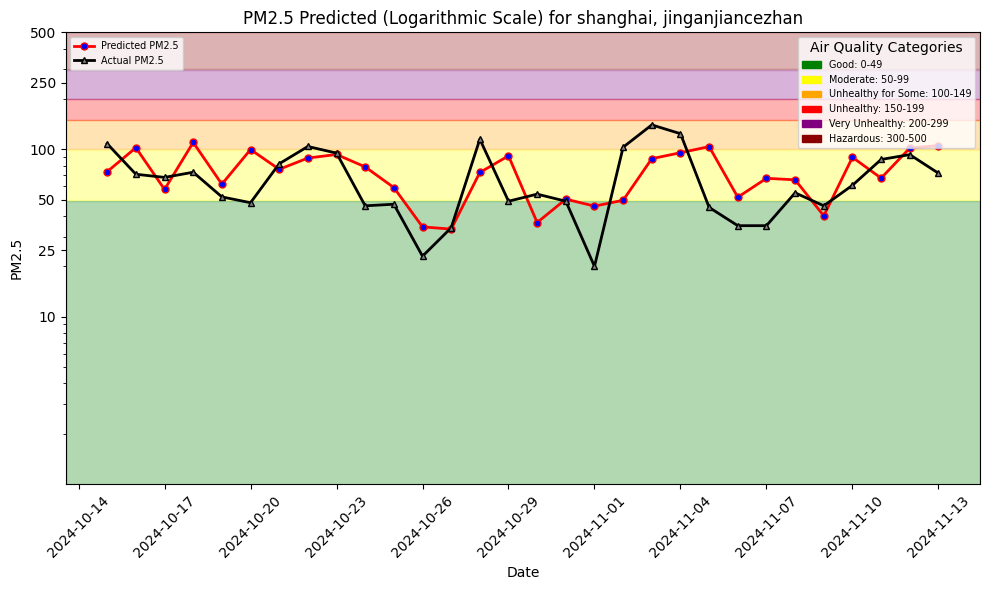

In [42]:
file_path = images_dir1 + "/pm25_hindcast1.png"
plt = util.plot_air_quality_forecast(city, street, df1, file_path, hindcast=True) 
plt.show()

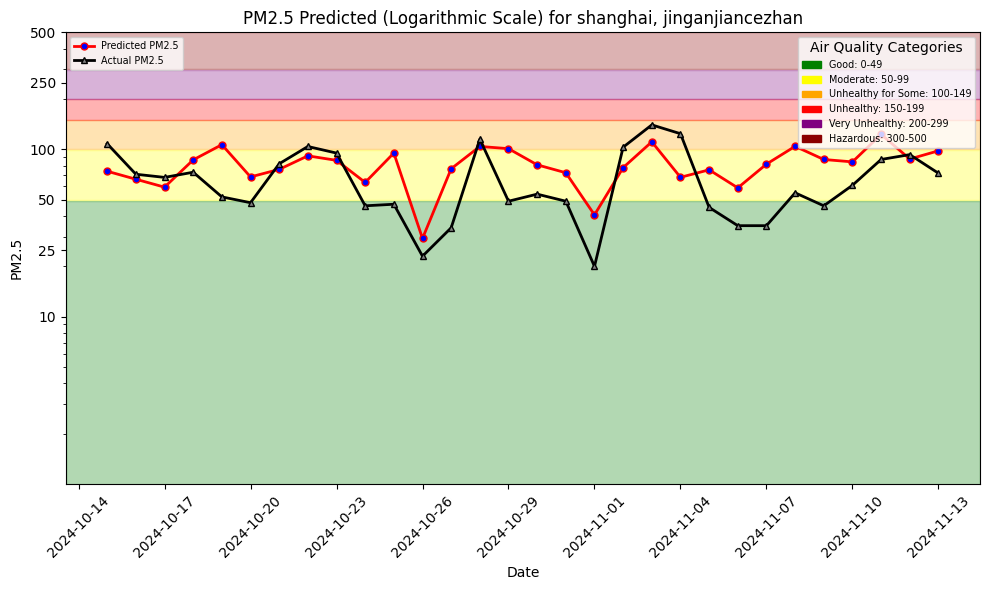

In [43]:
file_path = images_dir2 + "/pm25_hindcast2.png"
plt = util.plot_air_quality_forecast(city, street, df2, file_path, hindcast=True) 
plt.show()

In [ ]:
# display(weather_fg.features, len(weather_fg.features))

[Feature('date', 'timestamp', 'Date of measurement of weather', True, False, None, None, 1345973),
 Feature('temperature_2m_mean', 'float', 'Temperature in Celsius', False, False, None, None, 1345973),
 Feature('precipitation_sum', 'float', 'Precipitation (rain/snow) in mm', False, False, None, None, 1345973),
 Feature('wind_speed_10m_max', 'float', 'Wind speed at 10m abouve ground', False, False, None, None, 1345973),
 Feature('wind_direction_10m_dominant', 'float', 'Dominant Wind direction over the dayd', False, False, None, None, 1345973),
 Feature('city', 'string', 'City where weather is measured/forecast for', True, False, None, None, 1345973),
 Feature('pm25_1', 'float', 'Particles less than 2.5 micrometers in diameter (fine particles) pose health risk', False, False, None, None, 1345973),
 Feature('pm25_2', 'float', 'Particles less than 2.5 micrometers in diameter (fine particles) pose health risk', False, False, None, None, 1345973),
 Feature('pm25_3', 'float', 'Particles less 

26

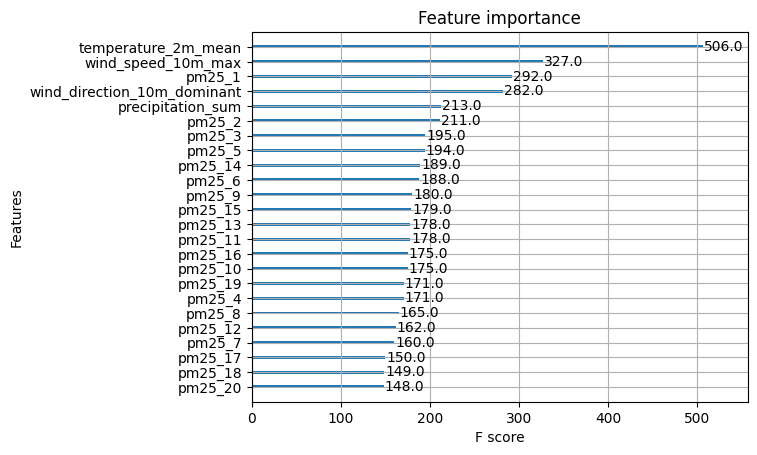

In [44]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor1, max_num_features=24)
feature_importance_path = images_dir1 + "/feature_importance1.png"
plt.savefig(feature_importance_path, bbox_inches='tight')
plt.show()

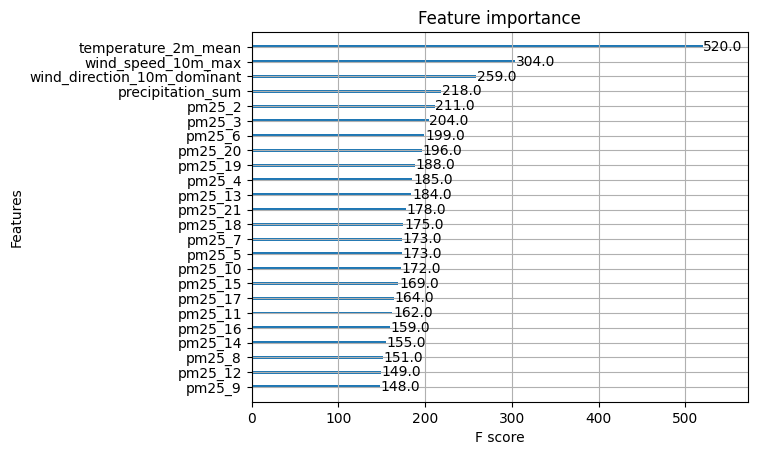

In [45]:
plot_importance(xgb_regressor2, max_num_features=24)
feature_importance_path = images_dir2 + "/feature_importance2.png"
plt.savefig(feature_importance_path, bbox_inches='tight')
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [46]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema1 = Schema(X_train1)
output_schema1 = Schema(y_train1)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema1 = ModelSchema(input_schema=input_schema1, output_schema=output_schema1)

# Converting the model schema to a dictionary representation
schema_dict1 = model_schema1.to_dict()

In [47]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema2 = Schema(X_train2)
output_schema2 = Schema(y_train2)

model_schema2 = ModelSchema(input_schema=input_schema2, output_schema=output_schema2)

schema_dict2 = model_schema2.to_dict()

In [48]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor1.save_model(model_dir1 + "/model1.json")

In [49]:
xgb_regressor2.save_model(model_dir2 + "/model2.json")

In [50]:
res_dict1 = { 
        "MSE": str(mse1),
        "R squared": str(r2_1),
    }

In [51]:
res_dict2 = { 
        "MSE": str(mse2),
        "R squared": str(r2_2),
    }

In [52]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model1 = mr.python.create_model(
    name="aq_xgboost_model_1", 
    version=1,
    metrics= res_dict1,
    model_schema=model_schema1,
    input_example=X_test1.sample().values, 
    description="Air Quality (PM2.5) predictor for today",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model1.save(model_dir1)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/546941 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/78965 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/66159 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/244 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2036 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1163420/models/aq_xgboost_model_1/1


Model(name: 'aq_xgboost_model_1', version: 1)

In [53]:
aq_model2 = mr.python.create_model(
    name="aq_xgboost_model_2", 
    version=1,
    metrics= res_dict2,
    model_schema=model_schema2,
    input_example=X_test2.sample().values, 
    description="Air Quality (PM2.5) predictor for next day",
)

aq_model2.save(model_dir2)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/531868 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/77488 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/66642 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/231 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2037 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1163420/models/aq_xgboost_model_2/1


Model(name: 'aq_xgboost_model_2', version: 1)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
